<h3>Predicting Exit Counts in NYC Subway Stations 2013 </h3>

<h6>Edwin Heredia, edw.delta@mail.com, July 2016</h6>


The data set consits of entry and exit counters measured every four hours at every turnstile available in stations in the NYC Subway System. <p>

This document examines the data and builds a predictive model for turnstile exit counts. In particular, this document shows an example of predicting exit counts for active turnstiles in station N203, unit R195 for 9/6 at 4pm and 8pm.<p>

<h4>Analysis</h4>
For any turnstile we define the exit count at day $n$ and time $t$ as $w(n, t)$. This number represents the accumulated value of the exit counter available in NYC subway turnstiles. The index $n$ designates the current day, $n-1$ designates the previous day, and so forth. The time $t$ represents the time when this measurement is taken. Normally $t$ adopts a value from the set $[0, 4, 8, 12, 16, 20]$ because the intent is for sampling to occur regularly every 4 hours. However a close examination of the data shows the following sampling problems:

<ul>
<li> Sometime machine counters (and possible machines) are reset at random times
<li> Sometimes machines stop recording samples probably due to failure
<li> Sometimes sampling occurs every 4 hours but it does not start exactly at midnith. Sometimes it starts at 1am and other times at 2am.
<li> Sometimes sampling can be delayed by an hour
</ul>

We introduce the concept of a <b>normalized exit count</b>, represented as $x(n, t)$,  and defined as the difference between the exit count at time $t$ and the exit count for the same machine and the same day at time $0$:<p>

<center>
$x(n, t) = w(n, t) - w(n, 0)$
</center>

In this expression, $w(n, t)$ and $w(n, 0)$ represent exit counts without normalization at time $t$ and $0$ respectively. The normalized exit count represents counter values that result from removing the historical accumulated count. In other words, we remove the sample value at 0:00 AM to get a normalized count value per day. The de-normalization process is straight forward. From the previous equation we can obtain a de-normalized using: <p>
<center>
$w(n, t) = x(n, t) + w(n, 0)$
</center>

In particular, the prediction model defined below uses normalized exit counts to implement a predictive moving average (MA) model using the three previous historic observations of $x(n, t)$. After using the model, the actual predicted exit count is found using the de-normalization equation. 

<h4>Data sources</h4>
The format of the data for the 2013 measurements is described here: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description_pre-10-18-2014.txt <p>

The following link provides a list of the web files containing the data: http://web.mta.info/developers/turnstile.html 

<h3>Software Description</h3>

The class <b>MonthHandler</b> defined below is used to programatically build the URLs to access the raw-data files.

In [7]:
%matplotlib inline

import urllib2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as smapi


constants = {"year": "13"}


class MonthHandler(object):
    """
    Methods to handle month information such as indices, codewords, and URLs
    """
    def __init__(self):
        self.index = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
                      "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}

        self.code = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun",
                     7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"}

        self.data_days = {6: [1, 8, 15, 22, 29], 7: [6, 13, 20, 27], 8: [3, 10, 17, 24, 31],
                          9: [7, 14, 21, 28], 10: [5, 12, 19, 26], 11: [2, 9, 16, 23, 30],
                          12: [7, 14, 21, 28]}

    def get_index(self, code):
        """Returns the month index given the 3-letter code"""
        return self.index.get(code, None)

    def get_code(self, index):
        """Returns the 3-letter code given the month index"""
        return self.code.get(index, None)

    def get_data_days(self, index):
        """Given a month defined by a numeric index return the days for data files"""
        return self.data_days.get(index, [])

    def get_url(self, day, month_index):
        """Given numeric values for day and month return the URL for the data file"""
        prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"

        month_str = str(month_index) if month_index >= 10 else "0"+ str(month_index)
        day_str = str(day) if day >= 10 else "0" + str(day)
        filename = constants["year"] + month_str + day_str + ".txt"

        return prefix + filename

The <b>extract_exit_count_data()</b> function is used to access and parse all the relevant raw data files for a particular month defined by a 3-letter code. This function depends on the <b>turnstile_exit_count_dataframe()</b> and <b>convert_to_array_for_exit_count()</b> functions. <p>

The <b>extract_exit_count_data()</b> function returns a dataframe with turnstile records for the specified month. The dataframe contains the following columns: 'ca', 'unit', 'scp', 'month', 'day', 'year', 'hour', and 'exit'. Columns 'ca', 'unit', and 'scp' define uniquely a turnstile in the system. Columns 'month', 'day', 'year', and 'hour' represent the timestamp for a particular data measurement. The columns called 'exit' contains the measured exit count. 

In [2]:
def turnstile_exit_count_dataframe(target_url, num_lines):
    """Given a raw-data URL covert the data into a dataframe for further analysis. Include exit count as
    one of the columns. The argument num_lines indicates the number of lines that should be parsed. A
    value of -1 indicates all lines.
    """
    webdata = urllib2.urlopen(target_url)

    table_data = []
    line_count = 0

    for line in webdata:
        values = line.strip().split(",")
        temp_array = convert_to_array_for_exit_count(values)
        table_data.extend(temp_array)

        if num_lines != -1 and line_count >= num_lines:
            break
        else:
            line_count += 1

    print "[Info] Total number of scanned lines: ", line_count

    tempdf = pd.DataFrame(table_data,
                           columns=["ca", "unit", "scp", "month", "day", "year", "hour", "exit"])

    # Remove records that for some unknown reason have a negative counter
    resultdf = tempdf[tempdf["exit"] > 0]

    return resultdf


def convert_to_array_for_exit_count(values):
    """Helper function for turnstile_exit_count_dataframe()"""
    reduced = []
    sta = values[0]
    unit = values[1]
    scp = values[2]

    for i in range(3, len(values), 5):
        vec = values[i:i + 5]

        if vec[2] == 'REGULAR':
            monval, dayval, yearval = [int(val) for val in vec[0].split("-")]
            timeval = int(vec[1].split(":")[0])
            exitval = int(vec[4])
            filtered_data = [sta, unit, scp, monval, dayval, yearval, timeval, exitval]
            reduced.append(filtered_data)

    return reduced


def extract_exit_count_data(month_code, numlines):
    print "[Info] Extracting data from: ", month_code

    dataframes = []

    # Get all the relevant URLs for the month
    mh = MonthHandler()
    m_ind = mh.get_index(month_code)
    d_days = mh.get_data_days(m_ind)
    urls = [mh.get_url(val, m_ind) for val in d_days]

    for url in urls:
        # print "full url: ", url
        print "[Info] Extracting data from file: ", url.split('/')[-1]
        df = turnstile_exit_count_dataframe(url, num_lines=numlines)
        dataframes.append(df)

    # Aggregate all tables into a single table containing all data
    agg_df = reduce(lambda df1, df2: pd.concat([df1, df2]), dataframes)

    return agg_df.reset_index(drop=True)


Functions <b>plot_group1()</b> and <b>plot_group2()</b> below are used to display graphs of normalized exit counts in a given business week (Monday - Friday). The argument 'init_day' defines the date (integer value) of the first day of the week (Monday). The argument 'df' defines the dataframe that contains the records for the target month.  <p>

Function <b>plot_group1()</b> shows 4 graphs for 4 different arbitrary devices (turnstile machines) at different stations. Function <b>plot_group2()</b> has a similar function except that the 4 arbitrary devices are actually devices in station 'N203' and unit 'R195'. <p>

Function <b>resquery_with_time_shift()</b> is a helper function used by functions <b>plot_group1()</b> and <b>plot_group2()</b>.

In [14]:
def resquery_with_time_shift(df, device, time_shift=0, day=-1):
    """Run a query to extract from a dataframe (df) the exit count for a certain day and a certain device. If 
    day is -1 it indicates all days. The device argument is a dictionary object with the 3 
    fields that identify a device: 'ca', 'unit', and 'scp'. The argument time-shift defines the starting time for 
    the 4-hour daily sampling period."""
    
    ca = device["ca"]
    unit = device["unit"]
    scp = device["scp"]

    # create a vector of 4-hour time samples
    time_samples = range(time_shift, 24, 4)

    if day == -1:
        return df[
            (df['ca'] == ca) &
            (df['unit'] == unit) &
            (df['scp'] == scp) &
            (df['hour'].isin(time_samples))]
    else:
        return df[
            (df['ca'] == ca) &
            (df['unit'] == unit) &
            (df['scp'] == scp) &
            (df['day'] == day) &
            (df['hour'].isin(time_samples))]

def plot_group1(init_day, df):
    """Plots a group of four graphs where each graph displays the normalized exit count for a device in a given
    week. The init_day argument is the first day in the week (Monday). The dataframe contains exit count data
    for the target month"""

    lbl = {0: {'day': 'mon', 'mark': 'o'},
           1: {'day': 'tue', 'mark': 'x'},
           2: {'day': 'wed', 'mark': 'D'},
           3: {'day': 'thu', 'mark': 'v'},
           4: {'day': 'fri', 'mark': 's'}}

    dev1 = {'ca': 'A002', 'unit': 'R051', 'scp': '02-00-00'}
    dev2 = {'ca': 'N203', 'unit': 'R195', 'scp': '00-00-00'}
    dev3 = {'ca': 'A013', 'unit': 'R081', 'scp': '01-00-00'}
    dev4 = {'ca': 'R729', 'unit': 'R292', 'scp': '00-00-00'}

    # compute graph for first device
    results1 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev1, time_shift=0, day=init_day+i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 1: ", " samples for day ", i, ": ", len(norm_day)
        results1.append(norm_day)

    # compute graph for second device
    results2 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev2, time_shift=0, day=init_day+i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 2: ", " samples for day ", i, ": ", len(norm_day)
        results2.append(norm_day)

    # compute graph for third device
    results3 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev3, time_shift=0, day=init_day + i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 3: ", " samples for day ", i, ": ", len(norm_day)
        results3.append(norm_day)

    # compute graph for fourth device - This device has been sampled with a 1-hour shift: 1, 5, 9, etc.
    results4 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev4, time_shift=1, day=init_day + i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 4: ", " samples for day ", i, ": ", len(norm_day)
        results4.append(norm_day)

    sub1 = plt.subplot(2, 2, 1)
    sub2 = plt.subplot(2, 2, 2)
    sub3 = plt.subplot(2, 2, 3)
    sub4 = plt.subplot(2, 2, 4)

    vec0 = [0, 4, 8, 12, 16, 20]   # shows sampling times starting with 0
    vec1 = [1, 5, 9, 13, 17, 21]   # shows sampling times starting with 1 (i.e. 1-hour shift)

    for k, res in enumerate(results1):
        if len(res) == 6:
            sub1.plot(vec0, res, marker=lbl[k]['mark'], label=lbl[k]["day"])

    for k, res in enumerate(results2):
        if len(res) == 6:
            sub2.plot(vec0, res, marker=lbl[k]['mark'], label=lbl[k]["day"])

    for k, res in enumerate(results3):
        if len(res) == 6:
            sub3.plot(vec0, res, marker=lbl[k]['mark'], label=lbl[k]["day"])

    for k, res in enumerate(results4):
        if len(res) == 6:
            sub4.plot(vec1, res, marker=lbl[k]['mark'], label=lbl[k]["day"])


    sub1.set_title('A002, R051, 02-00-00')
    sub1.set_ylabel('Normalized exit count')
    sub1.grid()
    sub1.legend(loc='upper left')

    sub2.set_title('N203, R195, 00-00-00')
    sub2.grid()

    sub3.set_title('A013, R081, 01-00-00')
    sub3.set_ylabel('Normalized exit count')
    sub3.set_xlabel('Hour')
    sub3.grid()

    sub4.set_title('R279, R292, 00-00-00')
    sub4.set_xlabel('Hour')
    sub4.grid()

    plt.show()

def plot_group2(init_day, df):
    """Plots a group of four graphs where each graph displays the normalized exit count for a device. In this case,
     the 4 devices happen to be co-located in the same unit and in the same station. Thge graph displays the
     normalized exit count in a given week. The init_day argument is the first day in the week (Monday).
     The dataframe contains exit count data for the target month"""
    lbl = {0: {'day': 'mon', 'mark': 'o'},
           1: {'day': 'tue', 'mark': 'x'},
           2: {'day': 'wed', 'mark': 'D'},
           3: {'day': 'thu', 'mark': 'v'},
           4: {'day': 'fri', 'mark': 's'}}

    dev000 = {'ca': 'N203', 'unit': 'R195', 'scp': '00-00-00'}
    dev001 = {'ca': 'N203', 'unit': 'R195', 'scp': '00-00-01'}
    dev002 = {'ca': 'N203', 'unit': 'R195', 'scp': '00-00-02'}
    dev003 = {'ca': 'N203', 'unit': 'R195', 'scp': '00-00-03'}

    # compute graph for device 000
    results1 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev000, time_shift=0, day=init_day + i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 1: ", " samples for day ", i, ": ", len(norm_day)
        results1.append(norm_day)

    # compute graph for device 001
    results2 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev001, time_shift=0, day=init_day + i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 2: ", " samples for day ", i, ": ", len(norm_day)
        results2.append(norm_day)

    # compute graph for device 002
    results3 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev002, time_shift=0, day=init_day + i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 3: ", " samples for day ", i, ": ", len(norm_day)
        results3.append(norm_day)

    # compute graph for device 003
    results4 = []
    for i in range(5):
        single_day = resquery_with_time_shift(df, dev003, time_shift=0, day=init_day + i)["exit"]
        norm_day = single_day - single_day.min()
        # print "device 4: ", " samples for day ", i, ": ", len(norm_day)
        results4.append(norm_day)

    sub1 = plt.subplot(2, 2, 1)
    sub2 = plt.subplot(2, 2, 2)
    sub3 = plt.subplot(2, 2, 3)
    sub4 = plt.subplot(2, 2, 4)

    vec0 = [0, 4, 8, 12, 16, 20]  # shows sampling times starting with 0

    for k, res in enumerate(results1):
        if len(res) == 6:
            sub1.plot(vec0, res, marker=lbl[k]['mark'], label=lbl[k]["day"])

    for k, res in enumerate(results2):
        if len(res) == 6:
            sub2.plot(vec0, res, marker=lbl[k]['mark'], label=lbl[k]["day"])

    for k, res in enumerate(results3):
        if len(res) == 6:
            sub3.plot(vec0, res, marker=lbl[k]['mark'], label=lbl[k]["day"])

    for k, res in enumerate(results4):
        if len(res) == 6:
            sub4.plot(vec0, res, marker=lbl[k]['mark'], label=lbl[k]["day"])

    titlestr1 = dev000['ca'] + ", " + dev000['unit'] + ", " + dev000["scp"]
    sub1.set_title(titlestr1)
    sub1.set_ylabel('Normalized exit count')
    sub1.grid()
    sub1.legend(loc='upper left')

    titlestr2 = dev001['ca'] + ", " + dev001['unit'] + ", " + dev001["scp"]
    sub2.set_title(titlestr2)
    sub2.grid()

    titlestr3 = dev002['ca'] + ", " + dev002['unit'] + ", " + dev002["scp"]
    sub3.set_title(titlestr3)
    sub3.set_ylabel('Normalized exit count')
    sub3.set_xlabel('Hour')
    sub3.grid()

    titlestr4 = dev003['ca'] + ", " + dev003['unit'] + ", " + dev003["scp"]
    sub4.set_title(titlestr4)
    sub4.set_xlabel('Hour')
    sub4.grid()

    plt.show()

    

The <b>Predictor</b> class defines some methods to predict exit counts for any turnstile using historic data. A predictor object can be instantiated from the class using the initialization method (constructor) with two arguments: 'device' and 'df'. The first argument is a dictionary object identifying the turnstile ('ca', 'unit', and 'scp'). The second argument is a pandas dataframe containing the historical data. <p> 

In this class, the <b>predict()</b> method implements the three strategies for prediction.


In [5]:
class Predictor(object):
    """Performs predictions for exit counts using historic data"""
    def __init__(self, device, df):
        """Class instance requires a device object and a dataframe with the data"""
        self.coeffs = []
        # self.target = target_date
        self.device = device
        self.df = df

    def set_coeffs(self, coeffs):
        """Sets the values of a coefficient vector that can be used for prediction"""
        self.coeffs = coeffs

    def get_exit_count(self, date):
        """Extracts exit count values for a given date"""
        exitrow = self.df[(self.df['ca'] == self.device["ca"]) &
                          (self.df["unit"] == self.device["unit"]) &
                          (self.df["scp"] == self.device["scp"]) &
                          (self.df["month"] == date["month"]) &
                          (self.df["day"] == date["day"]) &
                          (self.df["hour"] == date["hour"])]

        # This command converts a 1-row dataframe into a series using iloc[0]. Then it selects the
        # entry under the 'exit' label
        exitval = exitrow.iloc[0]['exit']

        return exitval

    def predict(self, date, strategy):
        """Predicts the exit count for a device defined by the class at a certain date (month, day, time) using 
         one of the prediction strategies"""
        # ndat1, ndat2, and ndat3 are the day/time objects for the initial count every day (normalization)
        date1 = {"month": date["month"], "day": date["day"] - 1, "hour": date["hour"]}
        ndat1 = {"month": date["month"], "day": date["day"] - 1, "hour": 0}

        date2 = {"month": date["month"], "day": date["day"] - 2, "hour": date["hour"]}
        ndat2 = {"month": date["month"], "day": date["day"] - 2, "hour": 0}

        date3 = {"month": date["month"], "day": date["day"] - 3, "hour": date["hour"]}
        ndat3 = {"month": date["month"], "day": date["day"] - 3, "hour": 0}

        # compute normalized values
        sam1 = self.get_exit_count(date1) - self.get_exit_count(ndat1)
        sam2 = self.get_exit_count(date2) - self.get_exit_count(ndat2)
        sam3 = self.get_exit_count(date3) - self.get_exit_count(ndat3)

        if strategy == 1:
            # compute the average of the 3 previous normalized values at the same time
            result = (sam1 + sam2 + sam3)/3.0

        elif strategy == 2:
            # compute weighted average of normalized values. The weights are selected using a heuristics
            # that emphasizes temporal closeness
            result = sam1*0.5 + sam2*0.3 + sam3*0.2

        elif strategy == 3:
            # Use coefficients trained using optimal least squares
            # Notice that the 1st coefficient corresponds to the sample at n-3, the 2nd at n-2, and the 3rd at n-1
            result = sam1*self.coeffs[2] + sam2*self.coeffs[1] + sam3*self.coeffs[0]
        else:
            print "[Error] Unknown strategy for prediction"
            result = 0.0

        # De-normalize the predicted result to generate the predicted value
        ndat0 = {"month": date["month"], "day": date["day"], "hour": 0}
        predval = int(round(self.get_exit_count(ndat0) + result))

        # extract the actual valuea from the stored records
        date0 = {"month": date["month"], "day": date["day"], "hour": date["hour"]}
        realval = int(self.get_exit_count(date0))

        # return real and predicted values
        return realval, predval

The final set of pre-defined functions defined below includes <b>training_procedure()</b> and <b>show_prediction_results()</b>.<p> 

Given the value of $t$ in $x(n, t)$, function <b>training_procedure()</b> extracts normalized exits counts $x(n, t)$, $x(n-1, t)$, $x(n-2, t)$ and $x(n-3, t)$. The function extracts these samples for multiple weeks selected from the months of June, July, and August 2013. These weeks were manually selected because they include complete sample sets (no missing samples in any day). Using the data from the selected weeks, this function uses a Least-Squares optimization algorithm to determine the 3 moving average coefficients that can be used to predict $x(n, t)$ using samples from the three previous days. <p>

The function <b>show_prediction_results()</b> is used to display the actual value, the predicted value, and the error in absolute and percentage forms. <p>

Functions <b>get_weekly_samples()</b> and <b>retrieve_exit_count()</b> are helper functions to perform specific tasks for the <b>training_procedure()</b> function. 

In [6]:
def training_procedure(jundf, juldf, augdf, device, target_hour):
    """Determines an optimal set of three moving average coefficients for prediction exit counts. This machine 
    learning procedure uses an ordinary least-squares algorithm to find the optimal coefficients. This function 
    selects specific weeks of June, July, and August 2013 for training."""
    # Get samples from weeks where Friday can be predicted from previous 3 days
    print "extracting training data for the week of jun 3..."
    res0 = get_weekly_samples(jundf, 'jun', 3, device, target_hour)
    print "extracting training data for the week of jun 10..."
    res1 = get_weekly_samples(jundf, 'jun', 10, device, target_hour)
    print "extracting training data for the week of jul 8..."
    res2 = get_weekly_samples(juldf, 'jul', 8, device, target_hour)
    print "extracting training data for the week of aug 5..."
    res3 = get_weekly_samples(augdf, 'aug', 5, device, target_hour)
    print "extracting training data for the week of aug 12..."
    res4 = get_weekly_samples(augdf, 'aug', 12, device, target_hour)
    print "extracting training data for the week of aug 19..."
    res5 = get_weekly_samples(augdf, 'aug', 19, device, target_hour)

    res_data = np.array([res0, res1, res2, res3, res4, res5])

    # print res_data

    dims = res_data.shape
    xmat = res_data[:, : dims[1] - 1 ]
    ycol = res_data[:, dims[1] - 1]
    print "\nobservation matrix (normalized exit counts): 1st col: Tue, 2nd col: Wed: 3rd col: Thu"
    print xmat
    print "\n observed ouput variable (normalized exit count): Fri"
    print ycol

    model = smapi.OLS(ycol, xmat)
    results = model.fit()

    print "\nCoefficients: ", results.params
    print "\n"

    return results.params


def get_weekly_samples(df, month_code, init_day, device, target_hour):
    """Extracts weekly historical samples (Tue - Fri) from a dataframe (df). The function uses a 3-letter codeword 
    for the target month, the device identifiers, and the target hour (integer)"""
    week_data = []
    for day in range(init_day + 1, init_day + 5): # from Tue to Fri
        mh = MonthHandler()
        month_index = mh.get_index(month_code)

        val = retrieve_exit_count(df, device, month_index, day, target_hour)
        nor = retrieve_exit_count(df, device, month_index, day, 0)  # Normalization factor

        week_data.append(val - nor)

    return week_data


def retrieve_exit_count(df, device, month_index, day, target_hour):
    """Extracts a record for a specic device, month, day, and hour"""
    singlerow = df[(df['ca'] == device["ca"]) &
                   (df["unit"] == device["unit"]) &
                   (df["scp"] == device["scp"]) &
                   (df["month"] == month_index) &
                   (df["day"] == day) &
                   (df["hour"] == target_hour)]

    # This command converts a 1-row dataframe into a series using iloc[0]. Then it selects the
    # entry under the 'exit' label
    exitval = singlerow.iloc[0]['exit']

    return exitval

def show_prediction_results(device, real_value, pred_value):
    """Displays prediction results and measures error values"""
    errval = abs(real_value - pred_value)
    errper = 100*errval/float(real_value)

    # print "\nca: ", device["ca"], "  unit: ", device["unit"], "  scp: ", device["scp"]
    print "actual value: ", real_value, "  prediction: ", \
        pred_value, "  abs error: ", errval, "  error (percent)): ", errper


<h4>Predictive Analytics</h4> This section shows the application of prediction methods to identify future values of exit counts at turnstile machines. The predictive model can be simple of complex but it needs to have some contextual support as to why it might be a reasonable model. The contextual analysis that we use to select a model is sometimes referred to as the hypothesis. If the contextual analysis (hypotheis) is correct, then we will end up with a model that can satisfactorily predict the outcome. <p>

One method for getting intuitive contextual information is of course plotting the signals to get an understanding on how the variables behave. In the turnstile case, we would like to predict an exit count value at a given turnstile machine given historical data for the same or other machines. Consequently, we show below normalized exit counts for different machines with data collected for one week during the summer of 2013. <p>

However, before plotting some historic data for turnstile exit counts we need to acquire the raw data from external sources and process the data so that it ends up stored in labeled pandas dataframes. The following code performs data acquisition. 

In [8]:
print "collecting june data from external sources..."
jundf = extract_exit_count_data("jun", numlines=-1)

print "collecting july data from external sources..."
juldf = extract_exit_count_data("jul", numlines=-1)

print "collecting aug data from external sources..."
augdf = extract_exit_count_data("aug", numlines=-1)

print "collecting sep data from external sources..."
sepdf = extract_exit_count_data("sep", numlines=-1)

collecting june data from external sources...
[Info] Extracting data from:  jun
[Info] Extracting data from file:  turnstile_130601.txt
[Info] Total number of scanned lines:  29943
[Info] Extracting data from file:  turnstile_130608.txt
[Info] Total number of scanned lines:  29640
[Info] Extracting data from file:  turnstile_130615.txt
[Info] Total number of scanned lines:  30187
[Info] Extracting data from file:  turnstile_130622.txt
[Info] Total number of scanned lines:  29525
[Info] Extracting data from file:  turnstile_130629.txt
[Info] Total number of scanned lines:  29638
collecting july data from external sources...
[Info] Extracting data from:  jul
[Info] Extracting data from file:  turnstile_130706.txt
[Info] Total number of scanned lines:  30964
[Info] Extracting data from file:  turnstile_130713.txt
[Info] Total number of scanned lines:  29504
[Info] Extracting data from file:  turnstile_130720.txt
[Info] Total number of scanned lines:  29287
[Info] Extracting data from file

The following code plots normalized exit counts for four different tursntile machines at different stations. The graphs show the increase in exit count per hour during a day. The graph shows data for the week of Aug 5, 2013.

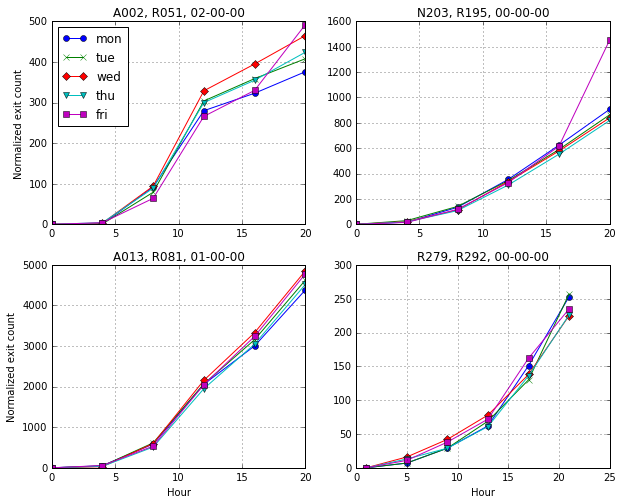

In [15]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plot_group1(5, augdf)

Like the previous figure, the following code plots similar normalized exit counts for four different turnstile machines for the week of Aug 5, 2013. However, in this case the turnstile machines are co-located within the same unit (R195) inside a particular station (N203). 

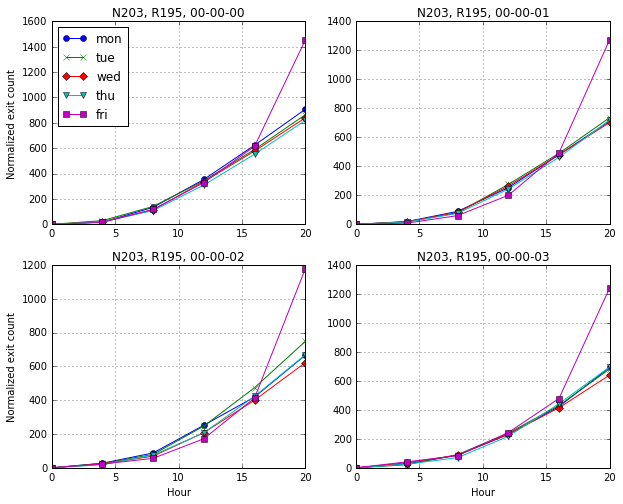

In [16]:
plot_group2(5, augdf)

From the graphs displayed above, we can extract some contextual information that will help us developing a predictive model. In particular: 

<ul>
<li>Different stations have different usage patterns. In fact the usage pattern could serve as a signature unique to the station. Compare for example the pattern of A002 and A013. For A002, usage tends to increase drastically during rush hour. For A013 the increase is linear except during night hours. 
<li> Stations co-located in the same unit within a station have similar usage patterns. When people exit a station using some designated area, they will choose any available turnstile machine. 
</ul>

In addition to the insights above, we can use similar plots to identify other important details that actually match with our intuitive use of a subway system: 

<ul>
<li> For many stations the usage patterns for work-days tend to be similar; i.e. Monday-Friday patterns. These patterns can be different from patterns during weekends (Saturday and Sunday). Patterns for holidays can be different than workdays and more similar to weekends. </li>
<li> Usage patterns have seasonal variations. Usage characteristics in winter can be different from those in summer time. </li>
<li> Specific events such as games near a station, nearby construction, malfunctions, etc. can alter the normal usage pattern during one or a few days. 
<li> In general, if we compare the data from two different days in a year, the usage patterns will show more differences when the temporal interval between the compared days is large. In other words, usage patterns tend to change over time. 
</ul>


<h4> Prediction Models </h4>
Taking into account the contextual information described above, we postulate three exit count predictor models. In this case, $w(n, t)$ represents the desired predicted value at a given day and time $t$. We perform prediction using data from a 3-day history; that is, we use $w(n-1, t)$, $w(n-2, t)$ and $w(n-3, t)$. <p>

For the three models, we first normalize the data to obtain $x(n-1, t)$, $x(n-2, t)$, and $x(n-3, t)$. We use the data to predict $x(n, t)$. Finally, we de-normalize the result to obtain $w(n, t)$. <p>

If ${\hat w}(n, t)$ represents the actual value, then the absolute prediction error is $E(n, t) = |{\hat w}(n, t) - w(n, t)|$. We also compute the percentage form of the prediction error, which is defined as $E'(n, t) = 100 \times E(n, t) / {\hat w}(n, t)$

The three models that we consider here are: 

<ul>
<li>Model 1: The predicted value is computed as a simple average:  
<center>
$x(n, t) \; = \; [ x(n-1, t) + x(n-2, t) + x(n-3, t)] \, / \, 3$
</center>
</li>
<li> Model 2: The predicted value is computed as a weighted average emphasizing the most recent data samples:
<center>
$x(n, t) \; = \; 0.5x(n-1, t) + 0.3x(n-2, t) + 0.2x(n-3, t)$
</center>
</li>
<li> Model 3: The predicted value is computed as a weighted average with the coefficients computed using a Least-Squares optimization procedure on historic data collected from selected weeks during the previous 3 months. That is:
<center>
$x(n, t) \; = \; a_1 x(n-1, t) + a_2 x(n-2, t) + a_3x(n-3, t)$
</center>
</li>
</ul>

The code below performs prediction for Sept 6, 2013 at 16:00 and also at 20:00 for five turnstile machines located in station N203, unit R195. The results with these limited number of devices show that the second model tends to generate smaller prediction errors. Of course, if we want to develop a more generic model and conduct a more thorough analysis, we will need to evaluate the models with a larger validation set. 


In [18]:
device000 = {"ca": "N203", "unit": "R195", "scp": "00-00-00"}
device001 = {"ca": "N203", "unit": "R195", "scp": "00-00-01"}
device002 = {"ca": "N203", "unit": "R195", "scp": "00-00-02"}
device003 = {"ca": "N203", "unit": "R195", "scp": "00-00-03"}
device004 = {"ca": "N203", "unit": "R195", "scp": "00-00-04"}

devlist = [device000, device001, device002, device003, device004]

ols_coeffs = training_procedure(jundf, juldf, augdf, device000, 16)

date = {'month': 9, 'day': 6, 'hour': 16}
print "***************** Exit count predictions for Sept 6 at 16:00 *************************"
for dev in devlist:
    print "----------------------------------------------------------------------------------"
    print "Device: ", dev['ca'], dev['unit'], dev['scp']


    pred = Predictor(dev, sepdf)

    print "\nStrategy 1 (mean):"
    realval, predval = pred.predict(date, strategy=1)
    show_prediction_results(dev, realval, predval)

    print "\nStrategy 2 (historic mean): "
    realval, predval = pred.predict(date, strategy=2)
    show_prediction_results(dev, realval, predval)

    print "\nStrategy 3 (least squares fit): "
    pred.set_coeffs(ols_coeffs)
    realval, predval = pred.predict(date, strategy=3)
    show_prediction_results(dev, realval, predval)


date = {'month': 9, 'day': 6, 'hour': 20}
print "\n***************** Exit count predictions for Sept 6 at 20:00 *************************"
for dev in devlist:
    print "----------------------------------------------------------------------------------"
    print "Device: ", dev['ca'], dev['unit'], dev['scp']

    pred = Predictor(dev, sepdf)

    print "\nStrategy 1 (mean):"
    realval, predval = pred.predict(date, strategy=1)
    show_prediction_results(dev, realval, predval)

    print "\nStrategy 2 (historic average): "
    realval, predval = pred.predict(date, strategy=2)
    show_prediction_results(dev, realval, predval)

    print "\nStrategy 3 (least squares fit): "
    pred.set_coeffs(ols_coeffs)
    realval, predval = pred.predict(date, strategy=3)
    show_prediction_results(dev, realval, predval)



extracting training data for the week of jun 3...
extracting training data for the week of jun 10...
extracting training data for the week of jul 8...
extracting training data for the week of aug 5...
extracting training data for the week of aug 12...
extracting training data for the week of aug 19...

observation matrix (normalized exit counts): 1st col: Tue, 2nd col: Wed: 3rd col: Thu
[[ 702 1132  628]
 [ 690  643  605]
 [ 702  746  918]
 [ 590  578  553]
 [ 652  679  965]
 [ 856  605  947]]

 observed ouput variable (normalized exit count): Fri
[609 700 727 616 578 559]

Coefficients:  [ 0.70112318  0.17521168  0.00679165]


***************** Exit count predictions for Sept 6 at 16:00 *************************
----------------------------------------------------------------------------------
Device:  N203 R195 00-00-00

Strategy 1 (mean):
actual value:  3653653   prediction:  3653677   abs error:  24   error (percent)):  0.000656876829847

Strategy 2 (historic mean): 
actual value: 

Finally, if we want to predict the number of users that will exit a station using a certain turnstile machine between 4pm and 8pm, we just need to substract the exit count at 16:00 from the exit count at 20:00. 